In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import tqdm
import seaborn as sns
import sys

import pyro
import graphviz
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from pyro.optim import Adam
import pyro.util


NSTEPS = 1000
NBINS = 20
NSEED = 1
NRANK = 1
TRAIN_FRAC = .8

ALPHA = 10
BETA = 2

In [2]:
def transfer_model(n_samp, n_drug, s_idx1, d_idx1, s_idx2, d_idx2, obs1=None, n_obs1=None, obs2=None, n_obs2=None, k=1, r=1):
    print('TRANSFER!')
    print('K = ' + str(k))
    if obs1 is None and n_obs1 is None:
        print('Error!: both obs1 and n_obs1 are None.')
    if obs1 is not None:
        n_obs1 = obs1.shape[0]
    if obs2 is None and n_obs2 is None:
        print('Error: both obs2 and n_obs2 are None')
    if obs2 is not None:
        n_obs2 = obs2.shape[0]
    # create global offset
    a1_sigma = pyro.param('a1_sigma', dist.Gamma(ALPHA, BETA), constraint=constraints.positive)
    a1 = pyro.sample('a1', dist.Normal(0, a1_sigma))   
    # create s
    s_sigma = pyro.param('s_sigma', dist.Gamma(ALPHA, BETA), constraint=constraints.positive)
    with pyro.plate('s_plate', n_samp):
        with pyro.plate('k_s', k):
            s = pyro.sample('s', dist.Normal(0, s_sigma))
    s = torch.transpose(s, 0, 1)
    # create d
    d_sigma = pyro.param('d_sigma', dist.Gamma(ALPHA, BETA), constraint=constraints.positive)
    with pyro.plate('d_plate', n_drug):
        with pyro.plate('k_d', k):
            d = pyro.sample('d', dist.Normal(0, d_sigma))
    # mat1 = sd
    mat1 = torch.matmul(s, d) # should be: n-samp x n-drug
    assert (mat1.shape[0] == n_samp) and (mat1.shape[1] == n_drug)
    mean1 = mat1[s_idx1, d_idx1] + a1
    sigma1 = pyro.sample('sigma1', dist.Gamma(ALPHA, BETA))
    with pyro.plate('data1_plate', n_obs1):
        data1 = pyro.sample('data1', dist.Normal(mean1, sigma1 * torch.ones(n_obs1)), obs=obs1)
    # create global offset
    a2_sigma = pyro.param('a2_sigma', dist.Gamma(ALPHA, BETA), constraint=constraints.positive)
    a2 = pyro.sample('a2', dist.Normal(0, a2_sigma))  
    # create W
    w_sigma = pyro.param('w_sigma', dist.Gamma(ALPHA, BETA), constraint=constraints.positive)
    with pyro.plate('w_row_plate', n_samp):
        with pyro.plate('r_row', r):
            w_row = pyro.sample('w_row', dist.Normal(0, w_sigma))
    with pyro.plate('w_col_plate', n_samp):
        with pyro.plate('r_col', r):
            w_col = pyro.sample('w_col', dist.Normal(0, w_sigma))
    w_col = torch.transpose(w_col, 0, 1)
    W = torch.matmul(w_col, w_row)
    assert (W.shape[0] == n_samp) and (W.shape[1] == n_samp)
    # s' = Ws
    spr = torch.matmul(W, s)
    assert (spr.shape[0] == n_samp) and (spr.shape[1] == k)
    mat2 = torch.matmul(spr, d)
    assert (mat2.shape[0] == n_samp) and (mat2.shape[1] == n_drug)
    mean2 = mat2[s_idx2, d_idx2] + a2
    sigma2 = pyro.sample('sigma2', dist.Gamma(ALPHA, BETA))
    with pyro.plate('data2_plate', n_obs2):
        data2 = pyro.sample('data2', dist.Normal(mean2, sigma2 * torch.ones(n_obs2)), obs=obs2)


In [3]:
def vectorized_model(n_samp, n_drug, s_idx, d_idx, obs=None, n_obs=None, k=1):
    print('VECTORIZED!')
    print('K = ' + str(k))
    if obs is None and n_obs is None:
        print('Error!: both obs and n_obs are None.')
    if obs is not None:
        n_obs = obs.shape[0]
    # create global offset
    a_sigma = pyro.param('a_sigma', dist.Gamma(ALPHA, BETA), constraint=constraints.positive)
    a = pyro.sample('a', dist.Normal(0, a_sigma))   
    # create s
    s_sigma = pyro.param('s_sigma', dist.Gamma(ALPHA, BETA), constraint=constraints.positive)
    with pyro.plate('s_plate', n_samp):
        with pyro.plate('k1', k):
            s = pyro.sample('s', dist.Normal(0, s_sigma))
    # create d
    d_sigma = pyro.param('d_sigma', dist.Gamma(ALPHA, BETA), constraint=constraints.positive)
    with pyro.plate('d_plate', n_drug):
        with pyro.plate('k2', k):
            d = pyro.sample('d', dist.Normal(0, d_sigma))
    # create data
    # rank-k matrix
    s = torch.transpose(s, 0, 1)
    mat = torch.matmul(s, d) # should be: n-samp x n-drug
    assert (mat.shape[0] == n_samp) and (mat.shape[1] == n_drug)
    mean = mat[s_idx, d_idx] + a
    sigma = pyro.sample('sigma', dist.Gamma(ALPHA, BETA))
    with pyro.plate('data_plate', n_obs):
        data = pyro.sample('data', dist.Normal(mean, sigma * torch.ones(n_obs)), obs=obs)
    return data

In [4]:
def get_unique_pairs(df, col1, col2):
    a = df[[col1, col2]].drop_duplicates()
    pairs = list(zip(a[col1], a[col2]))
    assert len(pairs) == len(set(pairs))
    return pairs

def get_train_test_indices(pairs, n_train):
    n_pairs = len(pairs)
    idx = np.random.permutation(n_pairs)
    train_idx = idx[:n_train]
    test_idx = idx[n_train:]
    assert set(train_idx).isdisjoint(set(test_idx))
    return train_idx, test_idx

def index_pairs(pairs, indices):
    p = np.array(pairs)
    idx = np.array(indices)
    return list(map(tuple, p[idx]))

def split_by_pairs(df, col1, col2, train_pairs, test_pairs):
    df['pair'] = list(zip(df[col1], df[col2]))
    train_df = df.loc[df['pair'].isin(train_pairs)]
    test_df = df.loc[df['pair'].isin(test_pairs)]
    assert set(train_df['pair']).isdisjoint(set(test_df['pair']))
    return train_df, test_df

def split_train_test(df):
    col1 = 'sample_id'
    col2 = 'drug_id'
    # get unique sample-drug pairs
    pairs = get_unique_pairs(df, col1, col2)
    n_train = int(np.ceil(len(pairs) * TRAIN_FRAC))
    train_idx, test_idx = get_train_test_indices(pairs, n_train)
    train_pairs = index_pairs(pairs, train_idx)
    test_pairs = index_pairs(pairs, test_idx)
    return split_by_pairs(df, col1, col2, train_pairs, test_pairs)

def get_obs_info(df, obs_name):
    s = df['sample_id'].to_numpy()
    d = df['drug_id'].to_numpy()
    obs = torch.Tensor(df[obs_name].to_numpy())
    return s, d, obs

def r_squared(means, test):
    pearson_corr = np.corrcoef(test, means)
    r = pearson_corr[0, 1]
    return np.power(r, 2)

def predict_mat2(s, d, w_row, w_col):
    W = np.matmul(np.transpose(w_col), w_row)
    s_prime = np.matmul(W, np.transpose(s))
    mat2 = np.matmul(s_prime, d)
    return mat2

def predict(s, d):
    mat = np.matmul(np.transpose(s), d)
    return mat

def get_r_squared(s_loc, d_loc, s_idx, d_idx, obs):
    mat = predict(s_loc, d_loc)
    means = mat[s_idx, d_idx]
    rsq = r_squared(means, obs)
    return rsq

In [36]:
def transfer_fit_k(split_seed, model_seed, data_dir, k, r, obs_name1, obs_name2, n_steps):
    pyro.util.set_rng_seed(split_seed)
    pyro.clear_param_store()
    # get data
    # DO: edit data_fn and split data functions
    data_fn = data_dir + '/rep-gdsc-ctd2-mean.csv'
    df = pd.read_csv(data_fn)
    n_samp = df['sample_id'].nunique()
    n_drug = df['drug_id'].nunique()
    # get base layer info
    s_idx1, d_idx1, obs_1 = get_obs_info(df, obs_name1)
    # split data
    train_df, test_df = split_train_test(df)
    s_idx2, d_idx2, obs_2 = get_obs_info(train_df, obs_name2)
    s_test_idx, d_test_idx, obs_test = get_obs_info(test_df, obs_name2)
    # fit model
    pyro.util.set_rng_seed(model_seed)
    adam_params = {"lr": 0.05}
    optimizer = pyro.optim.Adam(adam_params)
    autoguide = AutoNormal(transfer_model)
    svi = SVI(transfer_model, autoguide, optimizer, loss=Trace_ELBO())
    losses = []
    for step in tqdm.trange(n_steps):
        svi.step(n_samp, n_drug, s_idx1, d_idx1, s_idx2, d_idx2, obs_1, len(obs_1), obs_2, len(obs_2), r=r, k=k)
        loss = svi.evaluate_loss(n_samp, n_drug, s_idx1, d_idx1, s_idx2, d_idx2, obs_1, len(obs_1), obs_2, len(obs_2), r=r, k=k)
        losses.append(loss)
    print('FINAL LOSS DIFF: ' + str(losses[len(losses) - 1] - losses[len(losses) - 2]))
    # retrieve values out for s and d vectors
    s_loc = pyro.param("AutoNormal.locs.s").detach().numpy()
    s_scale = pyro.param("AutoNormal.scales.s").detach().numpy()
    d_loc = pyro.param("AutoNormal.locs.d").detach().numpy()
    d_scale = pyro.param("AutoNormal.scales.d").detach().numpy()
    # need to retrive w_col, w_row and reconstruct s'!
    w_row_loc = pyro.param("AutoNormal.locs.w_row").detach().numpy()
    w_col_loc = pyro.param("AutoNormal.locs.w_col").detach().numpy()
    # predict function: takes in w_row, w_col, s, d --> mat2
    mat2 = predict_mat2(s_loc, d_loc, w_row_loc, w_col_loc)
    # eval test rsq
    test_means = mat2[s_test_idx, d_test_idx]
    rsq_test = r_squared(test_means, obs_test.numpy())
    # eval train rsq
    train_means = mat2[s_idx2, d_idx2]
    rsq_train = r_squared(train_means, obs_2.numpy())
    return rsq_test, rsq_train, losses

def fit_k(split_seed, model_seed, data_dir, k, obs_name, n_steps):
    pyro.util.set_rng_seed(split_seed)
    pyro.clear_param_store()
    # get data
    data_fn = data_dir + '/rep-gdsc-ctd2-mean.csv'
    df = pd.read_csv(data_fn)
    n_samp = df['sample_id'].nunique()
    n_drug = df['drug_id'].nunique()
    # split dataset
    train_df, test_df = split_train_test(df)
    s_idx, d_idx, obs_train = get_obs_info(train_df, obs_name)
    s_test_idx, d_test_idx, obs_test = get_obs_info(test_df, obs_name)
    # fit model
    pyro.util.set_rng_seed(model_seed)
    adam_params = {"lr": 0.05}
    optimizer = Adam(adam_params)
    autoguide = AutoNormal(vectorized_model)
    svi = SVI(vectorized_model, autoguide, optimizer, loss=Trace_ELBO())
    losses = []
    for step in tqdm.trange(n_steps):
        svi.step(n_samp, n_drug, s_idx, d_idx, obs=obs_train, k=k)
        loss = svi.evaluate_loss(n_samp, n_drug, s_idx, d_idx, obs=obs_train, k=k)
        losses.append(loss)
    # retrieve values out for s and d vectors
    s_loc = pyro.param("AutoNormal.locs.s").detach().numpy()
    s_scale = pyro.param("AutoNormal.scales.s").detach().numpy()
    d_loc = pyro.param("AutoNormal.locs.d").detach().numpy()
    d_scale = pyro.param("AutoNormal.scales.d").detach().numpy()
    # get r-squared value wrt test set
    rsq_test = get_r_squared(s_loc, d_loc, s_test_idx, d_test_idx, obs_test)
    rsq_train = get_r_squared(s_loc, d_loc, s_idx, d_idx, obs_train)
    return rsq_test, rsq_train, losses

In [34]:
split_seed = 0
model_seed = 0
k = 1
r = 4
obs_name1 = 'REP_published_auc_mean'
obs_name2 = 'GDSC_published_auc_mean'
save_dir = '../results/2023-07-24'
n_steps = 1000
    
data_dir = '~/Documents/research/tansey/msk_intern/pyro_model/data'
rsq_test, rsq_train, losses = transfer_fit_k(split_seed, model_seed, data_dir, k, r, obs_name1, obs_name2, n_steps)
save_fn = save_dir + '/' + str(model_seed) + '.pkl'
print('rsq_test: ' + str(rsq_test))
print('rsq_train: ' + str(rsq_train))
vals_dict = {'split_seed': split_seed, 'model_seed': model_seed, 'k': k, 'r': r, 'obs_name1': obs_name1, 'obs_name2': obs_name2, 'n_steps': n_steps, 'rsq_train': rsq_train, 'rsq_test': rsq_test}
with open(save_fn, 'wb') as handle:
    pickle.dump(vals_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

  1%|▌                                                                                          | 6/1000 [00:00<00:16, 59.38it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


  2%|█▊                                                                                        | 20/1000 [00:00<00:15, 62.19it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


  3%|███                                                                                       | 34/1000 [00:00<00:18, 53.11it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


  5%|████▎                                                                                     | 48/1000 [00:00<00:16, 59.12it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


  6%|████▉                                                                                     | 55/1000 [00:00<00:15, 59.89it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


  7%|██████▏                                                                                   | 69/1000 [00:01<00:15, 60.24it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


  8%|███████▍                                                                                  | 83/1000 [00:01<00:14, 61.74it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 10%|████████▋                                                                                 | 97/1000 [00:01<00:14, 62.55it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 11%|█████████▉                                                                               | 111/1000 [00:01<00:14, 62.75it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 12%|███████████▏                                                                             | 125/1000 [00:02<00:14, 62.38it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 14%|████████████▎                                                                            | 139/1000 [00:02<00:13, 62.64it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 15%|█████████████▌                                                                           | 153/1000 [00:02<00:13, 63.18it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 16%|██████████████▏                                                                          | 160/1000 [00:02<00:13, 63.56it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 17%|███████████████▍                                                                         | 174/1000 [00:02<00:12, 64.16it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 19%|████████████████▋                                                                        | 188/1000 [00:03<00:12, 63.86it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 20%|█████████████████▉                                                                       | 202/1000 [00:03<00:12, 63.65it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 22%|███████████████████▏                                                                     | 216/1000 [00:03<00:12, 63.22it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 23%|████████████████████▍                                                                    | 230/1000 [00:03<00:12, 63.78it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 24%|█████████████████████▋                                                                   | 244/1000 [00:03<00:11, 63.60it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 26%|██████████████████████▉                                                                  | 258/1000 [00:04<00:11, 63.48it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 27%|████████████████████████▏                                                                | 272/1000 [00:04<00:11, 62.69it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 29%|█████████████████████████▍                                                               | 286/1000 [00:04<00:11, 63.03it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 29%|██████████████████████████                                                               | 293/1000 [00:04<00:11, 63.52it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 31%|███████████████████████████▎                                                             | 307/1000 [00:04<00:11, 62.50it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 32%|████████████████████████████▌                                                            | 321/1000 [00:05<00:10, 63.29it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 34%|█████████████████████████████▊                                                           | 335/1000 [00:05<00:10, 62.66it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 35%|███████████████████████████████                                                          | 349/1000 [00:05<00:10, 63.32it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 36%|████████████████████████████████▎                                                        | 363/1000 [00:05<00:10, 61.55it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 38%|█████████████████████████████████▌                                                       | 377/1000 [00:06<00:09, 62.53it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 38%|██████████████████████████████████▏                                                      | 384/1000 [00:06<00:09, 63.45it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 40%|███████████████████████████████████▍                                                     | 398/1000 [00:06<00:09, 62.89it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 41%|████████████████████████████████████▋                                                    | 412/1000 [00:06<00:09, 63.56it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 43%|█████████████████████████████████████▉                                                   | 426/1000 [00:06<00:09, 63.10it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 44%|███████████████████████████████████████▏                                                 | 440/1000 [00:07<00:08, 63.12it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 45%|████████████████████████████████████████▍                                                | 454/1000 [00:07<00:08, 63.14it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 47%|█████████████████████████████████████████▋                                               | 468/1000 [00:07<00:08, 62.85it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 48%|██████████████████████████████████████████▉                                              | 482/1000 [00:07<00:08, 63.05it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 49%|███████████████████████████████████████████▌                                             | 489/1000 [00:07<00:08, 63.03it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 50%|████████████████████████████████████████████▊                                            | 503/1000 [00:08<00:07, 62.40it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 52%|██████████████████████████████████████████████                                           | 517/1000 [00:08<00:07, 62.40it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 53%|███████████████████████████████████████████████▎                                         | 531/1000 [00:08<00:07, 62.81it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 55%|████████████████████████████████████████████████▌                                        | 545/1000 [00:08<00:07, 63.39it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 56%|█████████████████████████████████████████████████▊                                       | 559/1000 [00:08<00:06, 63.42it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 57%|██████████████████████████████████████████████████▉                                      | 573/1000 [00:09<00:06, 63.34it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 59%|████████████████████████████████████████████████████▏                                    | 587/1000 [00:09<00:06, 63.57it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 59%|████████████████████████████████████████████████████▊                                    | 594/1000 [00:09<00:06, 63.78it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 61%|██████████████████████████████████████████████████████                                   | 608/1000 [00:09<00:06, 62.91it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 62%|███████████████████████████████████████████████████████▎                                 | 622/1000 [00:09<00:05, 63.40it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 64%|████████████████████████████████████████████████████████▌                                | 636/1000 [00:10<00:05, 63.79it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 65%|█████████████████████████████████████████████████████████▊                               | 650/1000 [00:10<00:05, 64.05it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 66%|███████████████████████████████████████████████████████████                              | 664/1000 [00:10<00:05, 63.71it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 68%|████████████████████████████████████████████████████████████▎                            | 678/1000 [00:10<00:05, 63.82it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 69%|█████████████████████████████████████████████████████████████▌                           | 692/1000 [00:11<00:04, 63.57it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 71%|██████████████████████████████████████████████████████████████▊                          | 706/1000 [00:11<00:04, 63.72it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 72%|████████████████████████████████████████████████████████████████                         | 720/1000 [00:11<00:04, 63.70it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 73%|████████████████████████████████████████████████████████████████▋                        | 727/1000 [00:11<00:04, 63.58it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 74%|█████████████████████████████████████████████████████████████████▉                       | 741/1000 [00:11<00:04, 63.61it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 76%|███████████████████████████████████████████████████████████████████▏                     | 755/1000 [00:12<00:03, 63.84it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 77%|████████████████████████████████████████████████████████████████████▍                    | 769/1000 [00:12<00:03, 63.75it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 78%|█████████████████████████████████████████████████████████████████████▋                   | 783/1000 [00:12<00:03, 62.87it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 80%|██████████████████████████████████████████████████████████████████████▉                  | 797/1000 [00:12<00:03, 60.28it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 81%|████████████████████████████████████████████████████████████████████████▏                | 811/1000 [00:12<00:03, 60.95it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 82%|████████████████████████████████████████████████████████████████████████▊                | 818/1000 [00:13<00:02, 61.59it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 83%|██████████████████████████████████████████████████████████████████████████               | 832/1000 [00:13<00:02, 59.81it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 84%|███████████████████████████████████████████████████████████████████████████▏             | 845/1000 [00:13<00:02, 59.61it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 86%|████████████████████████████████████████████████████████████████████████████▍            | 859/1000 [00:13<00:02, 60.46it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 87%|█████████████████████████████████████████████████████████████████████████████▋           | 873/1000 [00:13<00:02, 61.74it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 89%|██████████████████████████████████████████████████████████████████████████████▉          | 887/1000 [00:14<00:01, 62.63it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 90%|████████████████████████████████████████████████████████████████████████████████▏        | 901/1000 [00:14<00:01, 62.88it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 91%|████████████████████████████████████████████████████████████████████████████████▊        | 908/1000 [00:14<00:01, 62.55it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 92%|██████████████████████████████████████████████████████████████████████████████████       | 922/1000 [00:14<00:01, 62.94it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 94%|███████████████████████████████████████████████████████████████████████████████████▎     | 936/1000 [00:14<00:01, 62.58it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 95%|████████████████████████████████████████████████████████████████████████████████████▌    | 950/1000 [00:15<00:00, 63.22it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 96%|█████████████████████████████████████████████████████████████████████████████████████▊   | 964/1000 [00:15<00:00, 63.49it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 98%|███████████████████████████████████████████████████████████████████████████████████████  | 978/1000 [00:15<00:00, 62.99it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


 99%|████████████████████████████████████████████████████████████████████████████████████████▎| 992/1000 [00:15<00:00, 63.50it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1


100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 62.63it/s]

TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
TRANSFER!
K = 1
FINAL LOSS DIFF: -353.8076171875
rsq_test: 0.5706973593606957
rsq_train: 0.6460387226044887


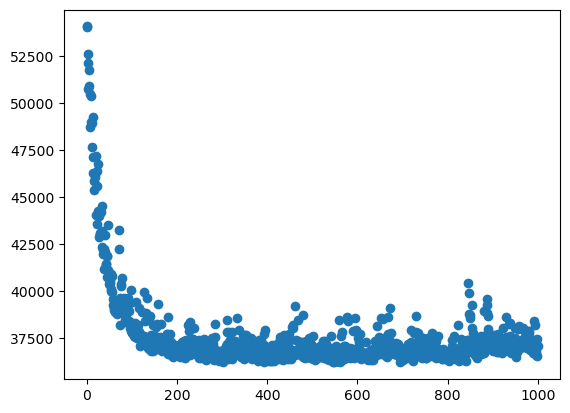

In [35]:
# plot loss as you go!!!
x_axis = range(0, len(losses))
plt.scatter(x_axis, losses)

In [19]:
split_seed = 0
model_seed = 0
k = 1
r = 1
obs_name1 = 'REP_published_auc_mean'
obs_name2 = 'GDSC_published_auc_mean'
obs_name3 = 'CTD2_published_auc_mean'
save_dir = '../results/2023-07-24'
n_steps = 1000
    
data_dir = '~/Documents/research/tansey/msk_intern/pyro_model/data'
rsq_test, rsq_train, losses = fit_k(split_seed, model_seed, data_dir, k, obs_name2, n_steps)
save_fn = save_dir + '/' + str(model_seed) + '.pkl'
print('rsq_test: ' + str(rsq_test))
print('rsq_train: ' + str(rsq_train))
vals_dict = {'split_seed': split_seed, 'model_seed': model_seed, 'k': k, 'r': r, 'obs_name1': obs_name1, 'obs_name2': obs_name2, 'n_steps': n_steps, 'rsq_train': rsq_train, 'rsq_test': rsq_test}
with open(save_fn, 'wb') as handle:
    pickle.dump(vals_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|                                                                                                   | 0/1000 [00:00<?, ?it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


  1%|█▏                                                                                       | 13/1000 [00:00<00:07, 125.38it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


  3%|██▍                                                                                      | 27/1000 [00:00<00:07, 130.40it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


  4%|███▋                                                                                     | 41/1000 [00:00<00:07, 129.94it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


  6%|████▉                                                                                    | 55/1000 [00:00<00:07, 130.74it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


  7%|██████▏                                                                                  | 69/1000 [00:00<00:07, 131.74it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 10%|████████▋                                                                                | 97/1000 [00:00<00:06, 132.60it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 12%|███████████                                                                             | 125/1000 [00:00<00:06, 133.35it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 15%|█████████████▍                                                                          | 153/1000 [00:01<00:06, 132.47it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 18%|███████████████▉                                                                        | 181/1000 [00:01<00:06, 132.77it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 21%|██████████████████▍                                                                     | 209/1000 [00:01<00:05, 132.58it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 24%|████████████████████▊                                                                   | 237/1000 [00:01<00:05, 133.33it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 26%|███████████████████████▎                                                                | 265/1000 [00:02<00:05, 132.42it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 29%|█████████████████████████▊                                                              | 293/1000 [00:02<00:05, 133.16it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 32%|████████████████████████████▏                                                           | 321/1000 [00:02<00:05, 133.33it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 35%|██████████████████████████████▋                                                         | 349/1000 [00:02<00:04, 133.61it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 38%|█████████████████████████████████▏                                                      | 377/1000 [00:02<00:04, 133.55it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED

 40%|███████████████████████████████████▋                                                    | 405/1000 [00:03<00:04, 133.61it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED

 43%|██████████████████████████████████████                                                  | 433/1000 [00:03<00:04, 133.35it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED

 46%|████████████████████████████████████████▌                                               | 461/1000 [00:03<00:04, 134.06it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED

 49%|███████████████████████████████████████████                                             | 489/1000 [00:03<00:03, 133.89it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 52%|█████████████████████████████████████████████▍                                          | 517/1000 [00:03<00:03, 133.20it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 55%|███████████████████████████████████████████████▉                                        | 545/1000 [00:04<00:03, 133.47it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED

 57%|██████████████████████████████████████████████████▍                                     | 573/1000 [00:04<00:03, 134.18it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED

 60%|████████████████████████████████████████████████████▉                                   | 601/1000 [00:04<00:02, 133.19it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 63%|███████████████████████████████████████████████████████▎                                | 629/1000 [00:04<00:02, 134.25it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED

 66%|█████████████████████████████████████████████████████████▊                              | 657/1000 [00:04<00:02, 133.14it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 68%|████████████████████████████████████████████████████████████▎                           | 685/1000 [00:05<00:02, 133.80it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 71%|██████████████████████████████████████████████████████████████▋                         | 713/1000 [00:05<00:02, 129.52it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 73%|███████████████████████████████████████████████████████████████▉                        | 726/1000 [00:05<00:02, 127.76it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 75%|██████████████████████████████████████████████████████████████████▏                     | 752/1000 [00:05<00:01, 125.31it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 78%|████████████████████████████████████████████████████████████████████▌                   | 779/1000 [00:05<00:01, 127.30it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 81%|███████████████████████████████████████████████████████████████████████                 | 807/1000 [00:06<00:01, 130.13it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 84%|█████████████████████████████████████████████████████████████████████████▍              | 835/1000 [00:06<00:01, 133.13it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED

 86%|███████████████████████████████████████████████████████████████████████████▉            | 863/1000 [00:06<00:01, 133.16it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED

 89%|██████████████████████████████████████████████████████████████████████████████▍         | 891/1000 [00:06<00:00, 134.99it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED

 92%|████████████████████████████████████████████████████████████████████████████████▊       | 919/1000 [00:06<00:00, 133.86it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 95%|███████████████████████████████████████████████████████████████████████████████████▎    | 947/1000 [00:07<00:00, 133.66it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1


 98%|█████████████████████████████████████████████████████████████████████████████████████▊  | 975/1000 [00:07<00:00, 134.88it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED

100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.41it/s]

VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
VECTORIZED!
K = 1
rsq_test: 0.6016267776240938
rsq_train: 0.6768759924565563


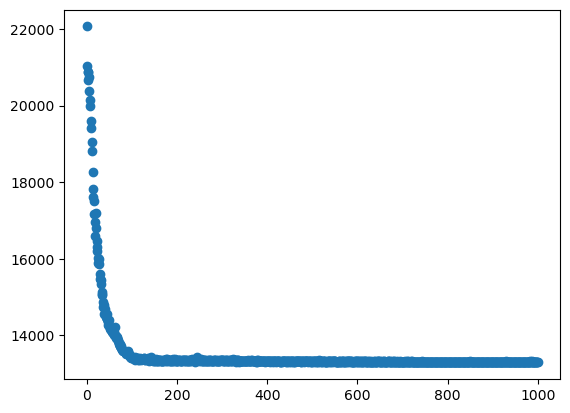

In [20]:
# plot loss as you go!!!
x_axis = range(0, len(losses))
plt.scatter(x_axis, losses)